In [49]:
## preprocessing of metafeatures
import numpy as np

filename = '/Users/hexuanliu/covid_features.txt'
with open(filename) as file:
    lines = file.readlines()
    lines = [(line.rstrip()).split(" ") for line in lines]
    print(lines)

lines = lines[1:]
meta_features = np.zeros((51,34))
for j, a in enumerate(lines):
    #print(a)
    for i in range(1,len(a)):
        meta_features[j][i-1]=float(a[i])

[['"x_acf1"', '"x_acf10"', '"diff1_acf1"', '"diff1_acf10"', '"diff2_acf1"', '"diff2_acf10"', '"ARCH.LM"', '"crossing_points"', '"entropy"', '"flat_spots"', '"arch_acf"', '"garch_acf"', '"arch_r2"', '"garch_r2"', '"alpha"', '"beta"', '"hurst"', '"lumpiness"', '"nonlinearity"', '"x_pacf5"', '"diff1x_pacf5"', '"diff2x_pacf5"', '"nperiods"', '"seasonal_period"', '"trend"', '"spike"', '"linearity"', '"curvature"', '"e_acf1"', '"e_acf10"', '"stability"', '"unitroot_kpss"', '"unitroot_pp"', '"series_length"'], ['"1"', '0.924657357851176', '2.29268186197937', '0.709239235888831', '0.885152830449506', '0.110881697656063', '0.371850809882701', '0.938295359912932', '6', '0.55085703187747', '11', '0.138129790070101', '0.0298471169771164', '0.183505198360499', '0.144319677273614', '0.999899965103052', '0.993005022298673', '0.99251926774938', '0.182425116242252', '0.246117393688872', '1.08120876495426', '0.715799741791315', '0.24201377999971', '0', '1', '0.960337271537456', '1.53654531116488e-06', '

In [50]:
print(meta_features)

[[  0.92465736   2.29268186   0.70923924 ...   0.44024147  -7.63539179
   57.        ]
 [  0.95613957   3.18127058   0.554645   ...   0.74878017  -4.96344975
   57.        ]
 [  0.92722602   2.73629623   0.34331125 ...   0.81071224  -6.03800986
   57.        ]
 ...
 [  0.95329973   3.80259272   0.28649611 ...   0.62585143  -3.55175584
   57.        ]
 [  0.91692937   1.93391102   0.5400222  ...   0.21332649  -9.3646203
   57.        ]
 [  0.74809113   2.26143612  -0.2281388  ...   0.66385184 -10.74286484
   57.        ]]


In [51]:
from scipy import linalg
import numpy as np

def pair_tensor(T,x1,x2):
    temp=x1[:,None] - x2 
    C=temp*T[:,:,None]
    ans = np.tensordot(C, temp, ([0,1],[0,1]))
    return ans

def dist(x1, x2):
    """ Compute squared euclidean distance between samples (autograd)
    """
    x1p2 = np.sum(np.square(x1), 1)
    x2p2 = np.sum(np.square(x2), 1)
    return x1p2.reshape((-1, 1)) + x2p2.reshape((1, -1)) - 2 * np.dot(x1, x2.T)


def sinkhorn(w1, w2, M, reg, k):
    """Sinkhorn algorithm with fixed number of iteration (autograd)
    """
    
    ## note: lambda=1/reg in paper
    K = np.exp(-M/reg )
    ui = np.ones((M.shape[0],))
    vi = np.ones((M.shape[1],))
    for i in range(k):
        vi = w2 / (np.dot(K.T, ui))
        ui = w1 / (np.dot(K, vi))
    G = ui.reshape((M.shape[0], 1)) * K * vi.reshape((1, M.shape[1]))
    return G


def split_classes(X, y):
    """split samples in X by classes in y
    """
    lstsclass = np.unique(y)
    return [X[y == i, :].astype(np.float32) for i in lstsclass]

def wda_eig(X, y, p, reg, P0, Breg=0, k=10, maxiter=100, verbose=0):
    """
    The function solves the ratio trace formulation of WDA.
    Parameters
    ----------
    X : ndarray, shape (n, d)
        Training samples.
    y : ndarray, shape (n,)
        Labels for training samples.
    p : int
        Size of reduced dimension.
    reg : float
        Wasserstein regularization term >0 (entropic regularization)
    P0 : ndarray, shape (d, p)
        Initial subspace for projection.
    Breg: float, optional, default set to 0
        Regularization for the B matrix in the denominator to make B positive definite
    k: int, optional, default set to 10
        Number of Sinkhorn iterations
    maxiter: int, optional, default set to 100
        Number of maximum number of iterations
    Returns
    -------
    P : ndarray, shape (d, p)
        Optimal transportation matrix for the given parameters
    proj : callable
        Projection function including mean centering
    obj: list
        List of angles s_k to measure the distance between consecutive subspaces
    
    """  
    mx = np.mean(X)
    X -= mx.reshape((1, -1))

    # data split between classes
    d = X.shape[1]
    xc = split_classes(X, y)
    # compute uniform weighs
    wc = [np.ones((x.shape[0]), dtype=np.float32) / x.shape[0] for x in xc]
    P=P0
    
    obj = []
    
    for it in range(maxiter):      
        loss_b = np.zeros((d,d))
        loss_w = np.zeros((d,d))
        for i, xi in enumerate(xc):
            pxi = np.dot(xi, P)
            for j, xj in enumerate(xc[i:]):
                pxj = np.dot(xj, P)
                M = dist(pxi, pxj)
                G = sinkhorn(wc[i], wc[j + i], M, reg, k)
                if j==0:
                    loss_w += pair_tensor(G, xi, xj)
                else:
                    loss_b += pair_tensor(G, xi, xj)
        if Breg==0:
            w, V = linalg.eig((loss_b+loss_b.T)/2, (loss_w+loss_w.T)/2)
        else:
            w, V = linalg.eig((loss_b+loss_b.T)/2, (loss_w+loss_w.T)/2+Breg*np.eye(d))
        w=np.real(w)
        V=np.real(V)
        #idx = np.argsort(w.real)
        #Pnew = np.real(V[:, 0:p])
        idx = np.argsort(-w)
        Pnew = V[:, idx[0:p]]
        

        Pinv = np.linalg.inv(P.T.dot(P))
        Pninv = np.linalg.inv(Pnew.T.dot(Pnew))
        
        ## s_k = ||sin\theta(P_{k-1}, P_k)||_2
        
        angle = np.linalg.norm((P.dot(Pinv.dot(P.T))-Pnew.dot(Pninv.dot(Pnew.T))),2)
        
        obj.append(angle)
        if (verbose==1):
            print("Iter: % 2d, angle: % 2.8f" %(it, angle))
            
        P=Pnew

        if (abs(angle)< 1e-3):
            break

    Popt = P

    def proj(X):
        return (X - mx.reshape((1, -1))).dot(Popt)

    return Popt, proj, obj

In [103]:
meanx = meta_features.mean(axis=0)
X = meta_features - meanx[np.newaxis,:]
X = X/linalg.norm(X,2)
x_train = X
print(x_train.shape)
d = 34
p = 3 ## number of PCs we want to keep

(51, 34)


In [104]:
#  wda Kmeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
d=x_train.shape[1]
Nc=10 ## number of classes

for rep in range(1):
    model1 = KMeans(n_clusters=Nc)
    model1.fit(x_train)
    T = model1.predict(x_train)
    targets = T

    

    Pwda = np.random.randn(10,p)
    alist=[]
    pca = PCA(n_components=10)
    x_train = pca.fit_transform(x_train) 
    for it in range(10):       
        Pwda, projwda, obj = wda_eig(x_train, targets, p, 0.01, Pwda)
        x_train_wda = projwda(x_train)
        wda_clustering = model1.fit(x_train_wda)
        targets = wda_clustering.labels_
        

In [105]:
Pwda

array([[ 0.11069095,  0.07435592, -0.02375603],
       [-0.12616145,  0.13961482,  0.24556092],
       [ 0.10764775, -0.09402049,  0.16049848],
       [ 0.0900517 ,  0.01679902,  0.64602912],
       [-0.20359312,  0.15663915,  0.11000304],
       [ 0.13677399,  0.15351548,  0.06507236],
       [-0.10671586, -0.22723271,  0.37572596],
       [-0.3083547 , -0.45124231, -0.33894194],
       [ 0.87549377, -0.51959436, -0.07080209],
       [ 0.13789828, -0.62651528,  0.46757079]])

In [106]:
targets.shape

(51,)

In [107]:
state_names = ["US","California","Texas","New York","Washington",'Alabama', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut','Delaware', 'Florida','Georgia','Idaho', 'Illinois','Indiana', 'Iowa',
               'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan','Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',  'North Carolina', 'North Dakota',
               'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee','Utah', 'Vermont', 'Virginia',  'West Virginia', 'Wisconsin', 'Wyoming','District of Columbia', 'Alaska']

['orange', 'magenta', 'blue', 'purple', 'orange', 'red', 'blue', 'yellow', 'navy', 'olive', 'orange', 'blue', 'red', 'yellow', 'blue', 'yellow', 'magenta', 'navy', 'blue', 'red', 'navy', 'olive', 'orange', 'orange', 'blue', 'magenta', 'yellow', 'navy', 'magenta', 'olive', 'olive', 'olive', 'yellow', 'magenta', 'cyan', 'blue', 'yellow', 'magenta', 'olive', 'olive', 'magenta', 'cyan', 'navy', 'blue', 'purple', 'red', 'navy', 'yellow', 'cyan', 'olive', 'olive']


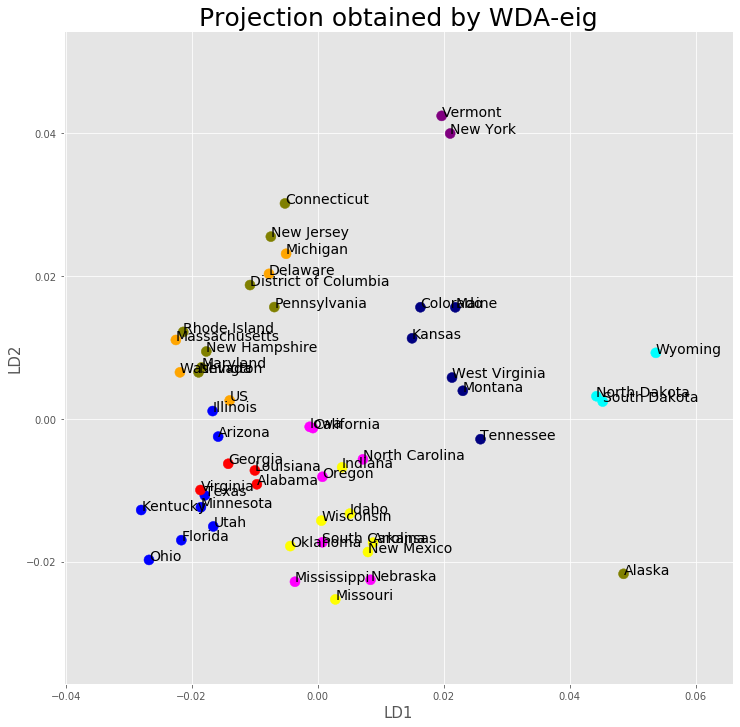

In [118]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
## change color scheme
colorlist = ['red','blue','yellow','purple','navy','cyan','orange','olive','olive','magenta','grey']
clist = []
for i in range(len(targets)):
    #print(y_pred[i])
    clist.append(colorlist[targets[i]])
print(clist)
plt.style.use('seaborn-dark-palette')

Xnew = projwda(x_train)
plt.figure(figsize=(12,12))
plt.scatter(Xnew[:,0],Xnew[:,1],s=100,c=clist)
plt.xlabel("LD1",fontsize=15)
plt.ylabel("LD2",fontsize=15)
plt.title("Projection obtained by WDA-eig",fontsize=25)
for i, label in enumerate(state_names):
    plt.annotate(label, (Xnew[i,0], Xnew[i,1]),fontsize=14)

plt.show()

In [119]:
for i in range(10):
    temp=[]
    for j in range(51):
        if targets[j]==i:
            temp.append(state_names[j])
    print(i, temp)

0 ['Alabama', 'Georgia', 'Louisiana', 'Virginia']
1 ['Texas', 'Arizona', 'Florida', 'Illinois', 'Kentucky', 'Minnesota', 'Ohio', 'Utah']
2 ['Arkansas', 'Idaho', 'Indiana', 'Missouri', 'New Mexico', 'Oklahoma', 'Wisconsin']
3 ['New York', 'Vermont']
4 ['Colorado', 'Kansas', 'Maine', 'Montana', 'Tennessee', 'West Virginia']
5 ['North Dakota', 'South Dakota', 'Wyoming']
6 ['US', 'Washington', 'Delaware', 'Massachusetts', 'Michigan']
7 ['Alaska']
8 ['Connecticut', 'Maryland', 'Nevada', 'New Hampshire', 'New Jersey', 'Pennsylvania', 'Rhode Island', 'District of Columbia']
9 ['California', 'Iowa', 'Mississippi', 'Nebraska', 'North Carolina', 'Oregon', 'South Carolina']
